https://www.kaggle.com/viridisquotient/arimax

In [2]:
import data_prep_helper
import statsmodels.api as sm
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import matplotlib.pyplot as plt

In [3]:
do = data_prep_helper.ChartData()

In [2]:
do.apply_boll_bands("bitcoin_hist", append_chart=True)

In [4]:
corr_df = do.chart_df


In [5]:
corr_df = corr_df.resample('D').interpolate()

In [6]:
#creating the train and validation set
train = corr_df[:int(0.8*(len(corr_df)))]
valid = corr_df[int(0.8*(len(corr_df))):]

In [7]:
months = train.index.month
dummy_months = pd.get_dummies(months)
dummy_months.columns = ['month-%s' % m for m in dummy_months.columns]
dummy_months.index = train.index



train['bitcoin_Price_prev_month'] = train['bitcoin_Price'].shift(31)
train['alibaba_Price_prev_month'] = train['alibaba_Price'].shift(31)
train['amazon_Price_prev_month'] = train['amazon_Price'].shift(31)
train['googl_Price_prev_month'] = train['googl_Price'].shift(31)
train['bitcoin_trends_prev_month'] = train['bitcoin_Google_Trends'].shift(31)
train['cryptocurrency_trends_prev_month'] = train['cryptocurrency_Google_Trends'].shift(31)
train['economy_pos_prev_month'] = train['economy_pos_sents'].shift(31)


train.fillna(0, inplace=True)
 
train = pd.concat([train, dummy_months], axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [8]:
months = valid.index.month
dummy_months = pd.get_dummies(months)
dummy_months.columns = ['month-%s' % m for m in dummy_months.columns]
dummy_months.index = valid.index

valid['bitcoin_Price_prev_month'] = valid['bitcoin_Price'].shift(31)
valid['alibaba_Price_prev_month'] = valid['alibaba_Price'].shift(31)
valid['amazon_Price_prev_month'] = valid['amazon_Price'].shift(31)

valid['googl_Price_prev_month'] = valid['googl_Price'].shift(31)
valid['bitcoin_trends_prev_month'] = valid['bitcoin_Google_Trends'].shift(31)
valid['cryptocurrency_trends_prev_month'] = valid['cryptocurrency_Google_Trends'].shift(31)
valid['economy_pos_prev_month'] = valid['economy_pos_sents'].shift(31)


valid = pd.concat([valid, dummy_months], axis=1)
#train.dropna(inplace=True)
#valid.dropna(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [25]:
%%time
s1i1 = train['bitcoin_Price']
exog_s1i1 = train[[
                   'bitcoin_Price_prev_month',
                   'alibaba_Price_prev_month',
                   'amazon_Price_prev_month',
                   'googl_Price_prev_month',
                   'bitcoin_trends_prev_month',
                   'cryptocurrency_trends_prev_month',
                   'month-1', 'month-2'
                   ]].fillna(0)
    

arimax = sm.tsa.statespace.SARIMAX(s1i1, exog=exog_s1i1,
                                   enforce_invertibility=False, enforce_stationarity=False, freq='D').fit()
print(arimax.summary())

                               SARIMAX Results                                
Dep. Variable:          bitcoin_Price   No. Observations:                 1511
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -10574.417
Date:                Tue, 31 Mar 2020   AIC                          21168.833
Time:                        20:40:01   BIC                          21222.032
Sample:                    01-08-2015   HQIC                         21188.645
                         - 02-26-2019                                         
Covariance Type:                  opg                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
bitcoin_Price_prev_month            -0.0562      0.041     -1.367      0.172      -0.137       0.024
alibaba_Price_prev_month            36.0388      5.923      6.084

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



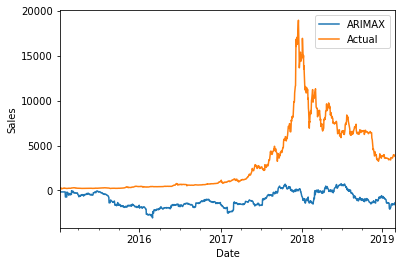

In [27]:


exog = train[[
                   'bitcoin_Price_prev_month',
                   'alibaba_Price_prev_month',
                   'amazon_Price_prev_month',
                   'googl_Price_prev_month',
                   'bitcoin_trends_prev_month',
                   'cryptocurrency_trends_prev_month',
                   'month-1', 'month-2'
                   ]].fillna(0)

forecast =  arimax.predict( dynamic=True, exog=exog)
actual = train["bitcoin_Price"]

forecast.plot()
actual.plot()
plt.legend(['ARIMAX', 'Actual'])
plt.ylabel('Sales');



In [30]:
exog = valid[[
                   'bitcoin_Price_prev_month',
                   'alibaba_Price_prev_month',
                   'amazon_Price_prev_month',
                   'googl_Price_prev_month',
                   'bitcoin_trends_prev_month',
                   'cryptocurrency_trends_prev_month',
                   'month-1', 'month-2'
                   ]].fillna(0)

In [31]:
forecast = arimax.get_forecast(steps=len(valid), exog=exog)

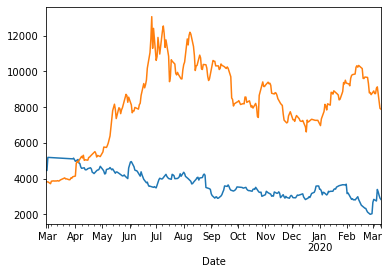

In [32]:
forecast.predicted_mean.plot()
valid["bitcoin_Price"].plot()

In [33]:
sqrt(mean_squared_error(forecast.predicted_mean, valid["bitcoin_Price"]))

5202.642429637899